Universidad Galileo

Data Science at Work

PAPD - Sección V

Allied Global - Grupo 1

# Modelo de Identificación de Cuentas

### Ensemble Learning

In [2]:
# https://www.kaggle.com/fengdanye/machine-learning-3-logistic-and-softmax-regression
# https://machinelearningmastery.com/calculate-feature-importance-with-python/

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import datasets, tree, svm, metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from matplotlib import pyplot
import graphviz
import pydotplus
from IPython.display import Image
from sklearn.metrics import plot_confusion_matrix

import os

In [3]:
#Ejemplo con Datos de Calidad de Vinos
TopPerformers_Cuenta = pd.read_csv('./winequality-red.csv')

TopPerformers_Cuenta = TopPerformers_Cuenta.rename(columns={'fixed acidity': 'Factor A', 'volatile acidity':'Factor B','citric acid':'Factor C',
                                                           'residual sugar':'Factor D','chlorides':'Factor E','free sulfur dioxide':'Factor F',
                                                           'total sulfur dioxide':'Factor G','density':'Factor H','pH':'Factor I','sulphates':'Factor J',
                                                           'alcohol':'Factor K','quality':'Cuenta'})

TopPerformers_Cuenta.head()

,Factor A,Factor B,Factor C,Factor D,Factor E,Factor F,Factor G,Factor H,Factor I,Factor J,Factor K,Cuenta
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Identificación de Cuentas Únicas

In [4]:
TopPerformers_Cuenta.Cuenta.unique()

array([5, 6, 7, 4, 8, 3], dtype=int64)

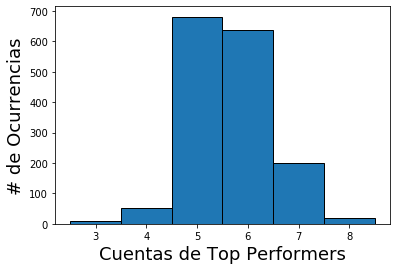

In [5]:
plt.hist(TopPerformers_Cuenta.Cuenta.values,bins=[2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5],edgecolor = 'black')
plt.xlabel('Cuentas de Top Performers', fontsize = 18)
plt.ylabel('# de Ocurrencias', fontsize = 18)
plt.show()

## Estandarización de Información
La estandarización se realiza con el objetivo de poder obtener coeficientes de importancia y determinar la relevancia de cada factor.

In [6]:
X = TopPerformers_Cuenta[TopPerformers_Cuenta.columns[0:11]].values
y = TopPerformers_Cuenta['Cuenta'].values

scaler = StandardScaler()
Xstan = scaler.fit_transform(X)
dataStanX = pd.DataFrame(data = Xstan, columns = TopPerformers_Cuenta.columns[0:11])
dataStanX

,Factor A,Factor B,Factor C,Factor D,Factor E,Factor F,Factor G,Factor H,Factor I,Factor J,Factor K
0,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246
1,-0.298547,1.967442,-1.391472,0.043416,0.223875,0.872638,0.624363,0.028261,-0.719933,0.128950,-0.584777
2,-0.298547,1.297065,-1.186070,-0.169427,0.096353,-0.083669,0.229047,0.134264,-0.331177,-0.048089,-0.584777
3,1.654856,-1.384443,1.484154,-0.453218,-0.264960,0.107592,0.411500,0.664277,-0.979104,-0.461180,-0.584777
4,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246
...,...,...,...,...,...,...,...,...,...,...,...
1594,-1.217796,0.403229,-0.980669,-0.382271,0.053845,1.542054,-0.075043,-0.978765,0.899886,-0.461180,0.072294
1595,-1.390155,0.123905,-0.877968,-0.240375,-0.541259,2.211469,0.137820,-0.862162,1.353436,0.601055,0.729364
1596,-1.160343,-0.099554,-0.723916,-0.169427,-0.243707,1.255161,-0.196679,-0.533554,0.705508,0.542042,0.541630
1597,-1.390155,0.654620,-0.775267,-0.382271,-0.264960,1.542054,-0.075043,-0.676657,1.677400,0.305990,-0.209308


### Modelo No. 1 Ensemble Learning: Regresión Logística

Se utilizará un modelo de regresión logística multinomial, lo cual se logra colocando el valor 'multinomial' al parámetro 'multi_class', con el objetivo de llevar a cabo la regresión con **softmax**. El optimizador será 'lbfgs' que soporta la regresión softmax.

In [7]:
dataStanRL = dataStanX.copy()
dataStanRL['Cuenta']=y
dataStanRL.head()

,Factor A,Factor B,Factor C,Factor D,Factor E,Factor F,Factor G,Factor H,Factor I,Factor J,Factor K,Cuenta
0,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,5
1,-0.298547,1.967442,-1.391472,0.043416,0.223875,0.872638,0.624363,0.028261,-0.719933,0.128950,-0.584777,5
2,-0.298547,1.297065,-1.186070,-0.169427,0.096353,-0.083669,0.229047,0.134264,-0.331177,-0.048089,-0.584777,5
3,1.654856,-1.384443,1.484154,-0.453218,-0.264960,0.107592,0.411500,0.664277,-0.979104,-0.461180,-0.584777,6
4,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,5


In [8]:
softReg = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs')
softReg.fit(Xstan,y)

C:\Users\Dell G5 15\.conda\envs\datascience\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(multi_class='multinomial')

Parámetros del Modelo:

In [9]:
softReg.intercept_,softReg.coef_

(array([-3.46809416, -0.10633227,  2.70514849,  2.85646912,  0.73231726,
        -2.71950844]),
 array([[ 0.3765725 ,  1.13211136,  0.18451538, -0.12008472,  0.71164931,
          0.34442631, -0.85254401,  0.6207801 ,  0.76870696, -0.58601018,
         -1.02666265],
        [ 0.29400791,  0.46069462, -0.01277362,  0.28915552,  0.26329311,
         -0.39213841,  0.26137482, -0.51565107,  0.42883224, -0.27553437,
         -0.66485884],
        [-0.46502038, -0.03877959, -0.06714979, -0.2267821 ,  0.16414962,
         -0.15568218,  0.77881185,  0.336904  , -0.21550194, -0.38893892,
         -0.56691954],
        [-0.20028683, -0.50282114, -0.31505365, -0.14854781,  0.04245042,
          0.06378744,  0.24334905,  0.21888429, -0.19037924,  0.01478347,
          0.23886405],
        [ 0.28592911, -0.82776957, -0.1485183 ,  0.19489544, -0.26450772,
          0.07373959, -0.06792155, -0.29189067, -0.07145601,  0.49891536,
          0.73551602],
        [-0.2912023 , -0.22343567,  0.35897998,  

### Importancia de Factores
Basados en el hecho de que los datos X están estandarizados y en la misma escala, los coeficientes nos dan una idea del peso que cada factor tiene sobre si se es Top_Performer en alguna cuenta específica. Por ejemplo, para la Cuenta 3 (en este ejemplo es la primera cuenta):

Factor: 0, Importancia: 0.37657
Factor: 1, Importancia: 1.13211
Factor: 2, Importancia: 0.18452
Factor: 3, Importancia: -0.12008
Factor: 4, Importancia: 0.71165
Factor: 5, Importancia: 0.34443
Factor: 6, Importancia: -0.85254
Factor: 7, Importancia: 0.62078
Factor: 8, Importancia: 0.76871
Factor: 9, Importancia: -0.58601
Factor: 10, Importancia: -1.02666


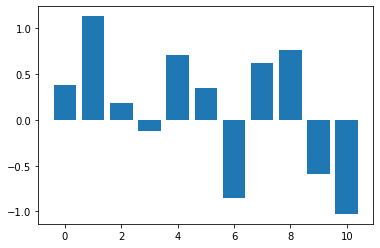

In [10]:
importance = softReg.coef_[0]

# Resumen de Importancias:
for i,v in enumerate(importance):
    print('Factor: %0d, Importancia: %.5f' % (i,v))

# Gráfico de Importancias
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

### Predicción con Regresión Logística

In [11]:
yhat = softReg.predict(Xstan)
dataStanRL['Prediccion_Cuenta'] = yhat
dataStanRL.head()

,Factor A,Factor B,Factor C,Factor D,Factor E,Factor F,Factor G,Factor H,Factor I,Factor J,Factor K,Cuenta,Prediccion_Cuenta
0,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,5,5
1,-0.298547,1.967442,-1.391472,0.043416,0.223875,0.872638,0.624363,0.028261,-0.719933,0.128950,-0.584777,5,5
2,-0.298547,1.297065,-1.186070,-0.169427,0.096353,-0.083669,0.229047,0.134264,-0.331177,-0.048089,-0.584777,5,5
3,1.654856,-1.384443,1.484154,-0.453218,-0.264960,0.107592,0.411500,0.664277,-0.979104,-0.461180,-0.584777,6,5
4,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,5,5


### Evaluación del Modelo Regresión Logística 

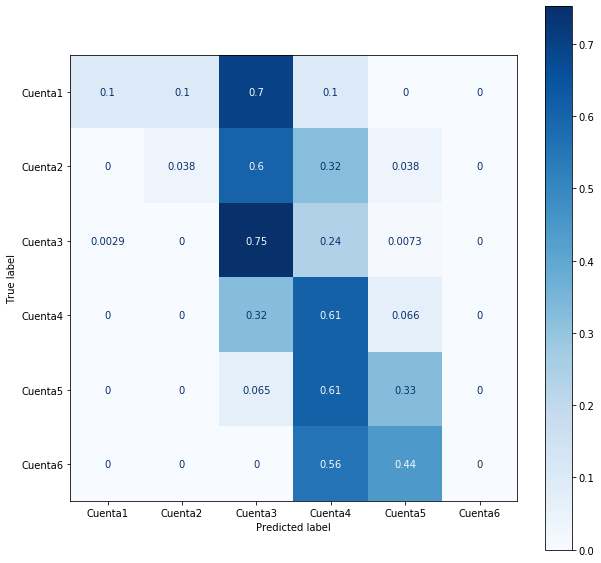

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_confusion_matrix(softReg, dataStanX, dataStanRL['Cuenta'].values,
                     display_labels=["Cuenta1","Cuenta2","Cuenta3","Cuenta4","Cuenta5","Cuenta6"],
                                 cmap=plt.cm.Blues,
                                 normalize='true',ax=ax)
plt.show()

Para evaluar el performance del modelo, se calcula la matriz de confusión C. Cada Cij es igual al número de observaciones que se conoce estan en el grupo i pero que se predijo estar en el grupo j. El orden de las columnas corresponde al orden de las cuentas. 

Un buen modelo tendrá la mayor parte de puntos en la diagonal.

In [13]:
print(classification_report(dataStanRL['Cuenta'].values, dataStanRL['Prediccion_Cuenta'].values, target_names=["Cuenta1","Cuenta2","Cuenta3","Cuenta4","Cuenta5","Cuenta6"]))

              precision    recall  f1-score   support

     Cuenta1       0.33      0.10      0.15        10
     Cuenta2       0.67      0.04      0.07        53
     Cuenta3       0.66      0.75      0.71       681
     Cuenta4       0.56      0.61      0.58       638
     Cuenta5       0.53      0.33      0.40       199
     Cuenta6       0.00      0.00      0.00        18

    accuracy                           0.61      1599
   macro avg       0.46      0.30      0.32      1599
weighted avg       0.60      0.61      0.59      1599



C:\Users\Dell G5 15\.conda\envs\datascience\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Modelo No. 2 Ensemble Learning: Arbol de Decisión
El segundo modelo se elige con el propósito de dar mayor interpretabilidad al modelo. Un arbol de decisión ayuda a determinar los niveles de los factores e igualmente identificar los de mayor importancia.

In [14]:
dataStanDT = dataStanX.copy()
dataStanDT['Cuenta']=y
dataStanDT.head()

,Factor A,Factor B,Factor C,Factor D,Factor E,Factor F,Factor G,Factor H,Factor I,Factor J,Factor K,Cuenta
0,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,5
1,-0.298547,1.967442,-1.391472,0.043416,0.223875,0.872638,0.624363,0.028261,-0.719933,0.128950,-0.584777,5
2,-0.298547,1.297065,-1.186070,-0.169427,0.096353,-0.083669,0.229047,0.134264,-0.331177,-0.048089,-0.584777,5
3,1.654856,-1.384443,1.484154,-0.453218,-0.264960,0.107592,0.411500,0.664277,-0.979104,-0.461180,-0.584777,6
4,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,5


Factor: 0, Importancia: 0.00000
Factor: 1, Importancia: 0.09570
Factor: 2, Importancia: 0.00000
Factor: 3, Importancia: 0.01253
Factor: 4, Importancia: 0.00385
Factor: 5, Importancia: 0.02731
Factor: 6, Importancia: 0.12315
Factor: 7, Importancia: 0.00000
Factor: 8, Importancia: 0.02185
Factor: 9, Importancia: 0.18845
Factor: 10, Importancia: 0.52716


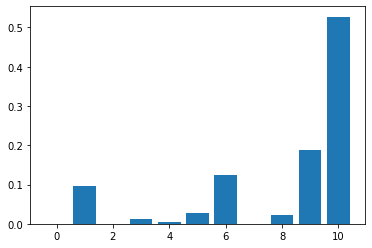

In [15]:
# Definición del modelo de Árbol de Decisión
#modelo_ArbolDecision = DecisionTreeRegressor(max_depth = 4 )
modelo_ArbolDecision = DecisionTreeClassifier(max_depth = 4 )

# Entrenamiento del Modelo
modelo_ArbolDecision.fit(Xstan,y)

# Cálculos de Importancia de Factores
importancia = modelo_ArbolDecision.feature_importances_

# Resumen de Importancias
for i,v in enumerate(importancia):
    print('Factor: %0d, Importancia: %.5f' % (i,v))

# Gráficos de Importancias
pyplot.bar([x for x in range(len(importancia))], importancia)
pyplot.show()

### Arbol de Decisión

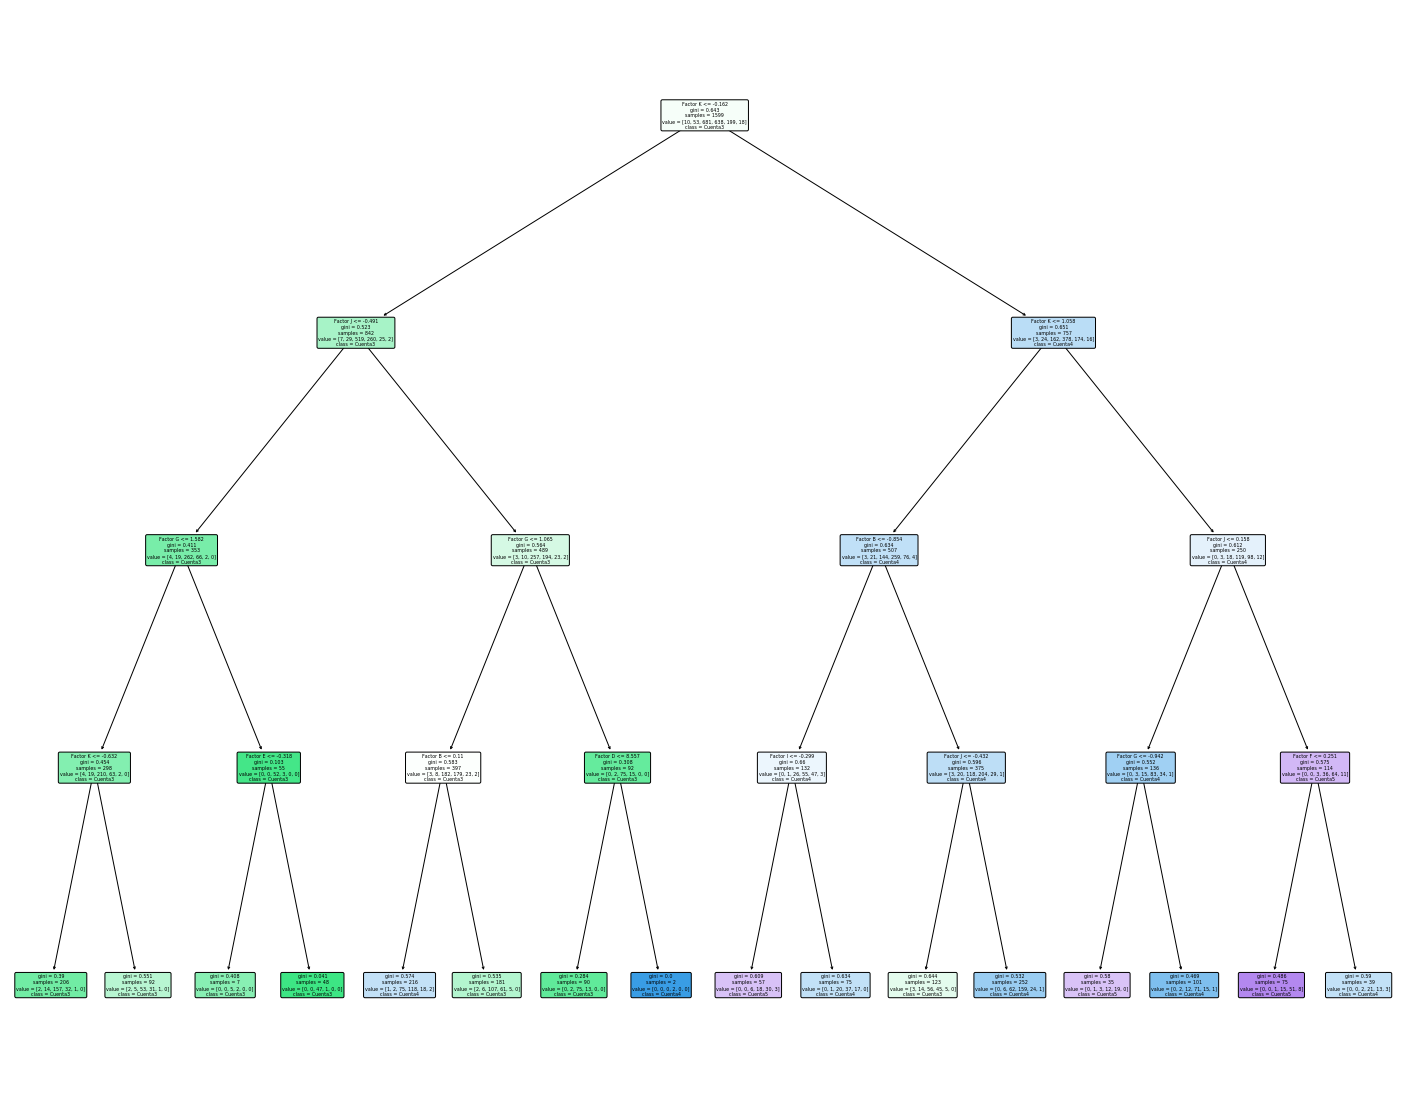

In [16]:
#text_representation = tree.export_text(modelo_ArbolDecision)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(modelo_ArbolDecision, 
                   feature_names=dataStanX.columns,  
                   class_names=["Cuenta1","Cuenta2","Cuenta3","Cuenta4","Cuenta5","Cuenta6"],
                   filled=True,
                   rounded=True)

In [17]:
yhat = modelo_ArbolDecision.predict(dataStanX)
dataStanDT['Prediccion_Cuenta'] = np.round(yhat)
dataStanDT['Prediccion_Cuenta'] = dataStanDT['Prediccion_Cuenta'].astype(int)
dataStanDT.head()

,Factor A,Factor B,Factor C,Factor D,Factor E,Factor F,Factor G,Factor H,Factor I,Factor J,Factor K,Cuenta,Prediccion_Cuenta
0,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,5,5
1,-0.298547,1.967442,-1.391472,0.043416,0.223875,0.872638,0.624363,0.028261,-0.719933,0.128950,-0.584777,5,5
2,-0.298547,1.297065,-1.186070,-0.169427,0.096353,-0.083669,0.229047,0.134264,-0.331177,-0.048089,-0.584777,5,5
3,1.654856,-1.384443,1.484154,-0.453218,-0.264960,0.107592,0.411500,0.664277,-0.979104,-0.461180,-0.584777,6,6
4,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,5,5


In [18]:
accuracy_score(dataStanDT['Cuenta'].values, dataStanDT['Prediccion_Cuenta'])

0.6303939962476548

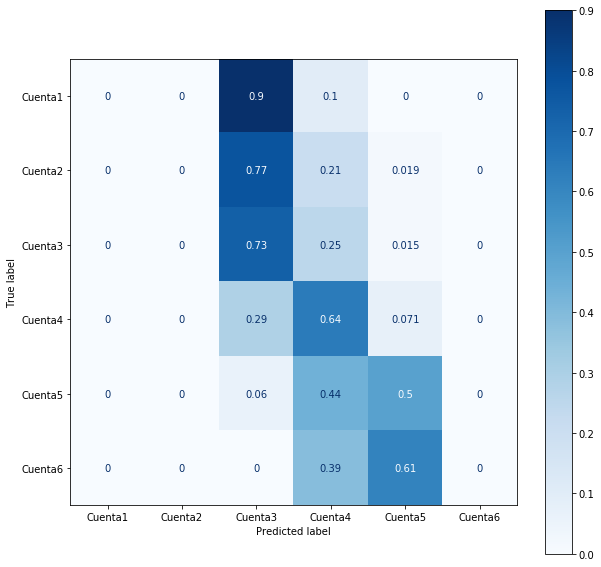

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_confusion_matrix(modelo_ArbolDecision, dataStanX, dataStanDT['Cuenta'].values,
                     display_labels=["Cuenta1","Cuenta2","Cuenta3","Cuenta4","Cuenta5","Cuenta6"],
                                 cmap=plt.cm.Blues,
                                 normalize='true', ax=ax)

plt.show()

In [20]:
print(classification_report(dataStanDT['Cuenta'].values, dataStanDT['Prediccion_Cuenta'].values, target_names=["Cuenta1","Cuenta2","Cuenta3","Cuenta4","Cuenta5","Cuenta6"]))

              precision    recall  f1-score   support

     Cuenta1       0.00      0.00      0.00        10
     Cuenta2       0.00      0.00      0.00        53
     Cuenta3       0.67      0.73      0.70       681
     Cuenta4       0.60      0.64      0.62       638
     Cuenta5       0.60      0.50      0.55       199
     Cuenta6       0.00      0.00      0.00        18

    accuracy                           0.63      1599
   macro avg       0.31      0.31      0.31      1599
weighted avg       0.60      0.63      0.61      1599



C:\Users\Dell G5 15\.conda\envs\datascience\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Modelo No. 3 Ensemble Learning: SVM
El tercer modelo se elige con el propósito de dar mayor interpretabilidad al modelo, utilizando una SVM con kernel lineal para determinar la importancia de los factores.

In [21]:
dataStanSVM = dataStanX.copy()
dataStanSVM['Cuenta']=y
dataStanSVM.head()

,Factor A,Factor B,Factor C,Factor D,Factor E,Factor F,Factor G,Factor H,Factor I,Factor J,Factor K,Cuenta
0,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,5
1,-0.298547,1.967442,-1.391472,0.043416,0.223875,0.872638,0.624363,0.028261,-0.719933,0.128950,-0.584777,5
2,-0.298547,1.297065,-1.186070,-0.169427,0.096353,-0.083669,0.229047,0.134264,-0.331177,-0.048089,-0.584777,5
3,1.654856,-1.384443,1.484154,-0.453218,-0.264960,0.107592,0.411500,0.664277,-0.979104,-0.461180,-0.584777,6
4,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,5


In [22]:
# Definición del modelo SVM con Kernel Lineal
modelo_SVM = svm.SVC(kernel='linear',C=0.3)

# Entrenamiento del Modelo
modelo_SVM.fit(Xstan,y)

# Cálculos de Importancia de Factores
def f_importancias(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

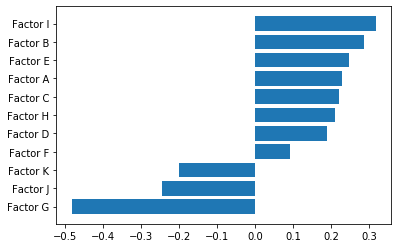

In [23]:
# Importancia de Factores en Cuenta No. 1
f_importancias(modelo_SVM.coef_[0], dataStanX.columns)

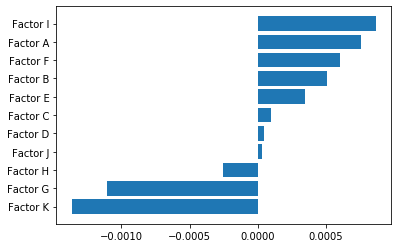

In [24]:
# Importancia de Factores en Cuenta No. 2
f_importancias(modelo_SVM.coef_[1], dataStanX.columns)

In [25]:
yhat = modelo_SVM.predict(dataStanX)
dataStanSVM['Prediccion_Cuenta'] = np.round(yhat)
dataStanSVM['Prediccion_Cuenta'] = dataStanSVM['Prediccion_Cuenta'].astype(int)
dataStanDT.head()

,Factor A,Factor B,Factor C,Factor D,Factor E,Factor F,Factor G,Factor H,Factor I,Factor J,Factor K,Cuenta,Prediccion_Cuenta
0,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,5,5
1,-0.298547,1.967442,-1.391472,0.043416,0.223875,0.872638,0.624363,0.028261,-0.719933,0.128950,-0.584777,5,5
2,-0.298547,1.297065,-1.186070,-0.169427,0.096353,-0.083669,0.229047,0.134264,-0.331177,-0.048089,-0.584777,5,5
3,1.654856,-1.384443,1.484154,-0.453218,-0.264960,0.107592,0.411500,0.664277,-0.979104,-0.461180,-0.584777,6,6
4,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,5,5


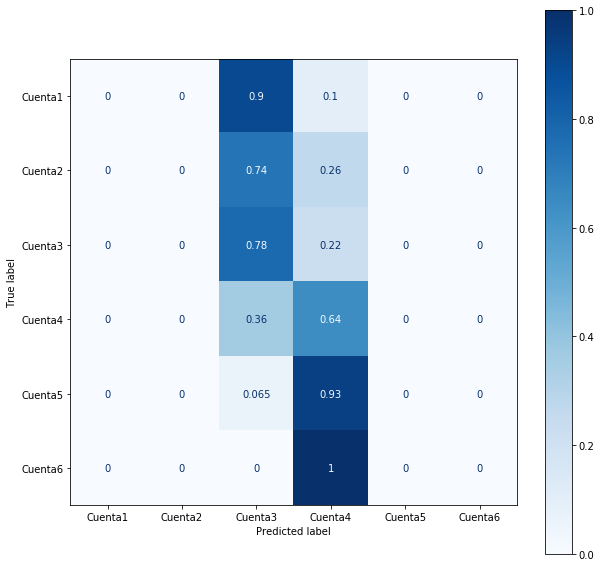

In [26]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_confusion_matrix(modelo_SVM, dataStanX, dataStanSVM['Cuenta'].values,
                     display_labels=["Cuenta1","Cuenta2","Cuenta3","Cuenta4","Cuenta5","Cuenta6"],
                                 cmap=plt.cm.Blues,
                                 normalize='true', ax=ax)

plt.show()

In [27]:
print(classification_report(dataStanSVM['Cuenta'].values, dataStanSVM['Prediccion_Cuenta'].values, target_names=["Cuenta1","Cuenta2","Cuenta3","Cuenta4","Cuenta5","Cuenta6"]))

              precision    recall  f1-score   support

     Cuenta1       0.00      0.00      0.00        10
     Cuenta2       0.00      0.00      0.00        53
     Cuenta3       0.65      0.78      0.71       681
     Cuenta4       0.52      0.64      0.58       638
     Cuenta5       0.00      0.00      0.00       199
     Cuenta6       0.00      0.00      0.00        18

    accuracy                           0.59      1599
   macro avg       0.20      0.24      0.21      1599
weighted avg       0.48      0.59      0.53      1599



C:\Users\Dell G5 15\.conda\envs\datascience\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Modelo No. 4 Ensemble Learning: Naive Bayes
El cuarto modelo se elige con el propósito de dar mayor interpretabilidad al modelo, utilizando un modelo probabilístico.

In [52]:
from sklearn.ensemble import RandomForestClassifier

In [53]:
dataStanRF = dataStanX.copy()
dataStanRF['Cuenta']=y
dataStanRF.head()

,Factor A,Factor B,Factor C,Factor D,Factor E,Factor F,Factor G,Factor H,Factor I,Factor J,Factor K,Cuenta
0,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,5
1,-0.298547,1.967442,-1.391472,0.043416,0.223875,0.872638,0.624363,0.028261,-0.719933,0.128950,-0.584777,5
2,-0.298547,1.297065,-1.186070,-0.169427,0.096353,-0.083669,0.229047,0.134264,-0.331177,-0.048089,-0.584777,5
3,1.654856,-1.384443,1.484154,-0.453218,-0.264960,0.107592,0.411500,0.664277,-0.979104,-0.461180,-0.584777,6
4,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,5


Factor: 0, Importancia: 0.08219
Factor: 1, Importancia: 0.10066
Factor: 2, Importancia: 0.09415
Factor: 3, Importancia: 0.07524
Factor: 4, Importancia: 0.06786
Factor: 5, Importancia: 0.06633
Factor: 6, Importancia: 0.10662
Factor: 7, Importancia: 0.09424
Factor: 8, Importancia: 0.07209
Factor: 9, Importancia: 0.09571
Factor: 10, Importancia: 0.14492


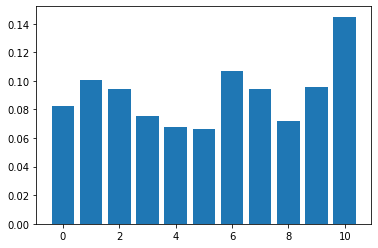

In [54]:
# Definición del modelo SVM con Kernel Lineal
modelo_RF = RandomForestClassifier(max_depth=10, n_estimators=10, max_features=1)

# Entrenamiento del Modelo
modelo_RF.fit(Xstan,y)

# Cálculos de Importancia de Factores
importancia = modelo_RF.feature_importances_

# Resumen de Importancias
for i,v in enumerate(importancia):
    print('Factor: %0d, Importancia: %.5f' % (i,v))

# Gráficos de Importancias
pyplot.bar([x for x in range(len(importancia))], importancia)
pyplot.show()


In [55]:
yhat = modelo_RF.predict(dataStanX)
dataStanRF['Prediccion_Cuenta'] = np.round(yhat)
dataStanRF.head()

,Factor A,Factor B,Factor C,Factor D,Factor E,Factor F,Factor G,Factor H,Factor I,Factor J,Factor K,Cuenta,Prediccion_Cuenta
0,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,5,5
1,-0.298547,1.967442,-1.391472,0.043416,0.223875,0.872638,0.624363,0.028261,-0.719933,0.128950,-0.584777,5,5
2,-0.298547,1.297065,-1.186070,-0.169427,0.096353,-0.083669,0.229047,0.134264,-0.331177,-0.048089,-0.584777,5,5
3,1.654856,-1.384443,1.484154,-0.453218,-0.264960,0.107592,0.411500,0.664277,-0.979104,-0.461180,-0.584777,6,6
4,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,5,5


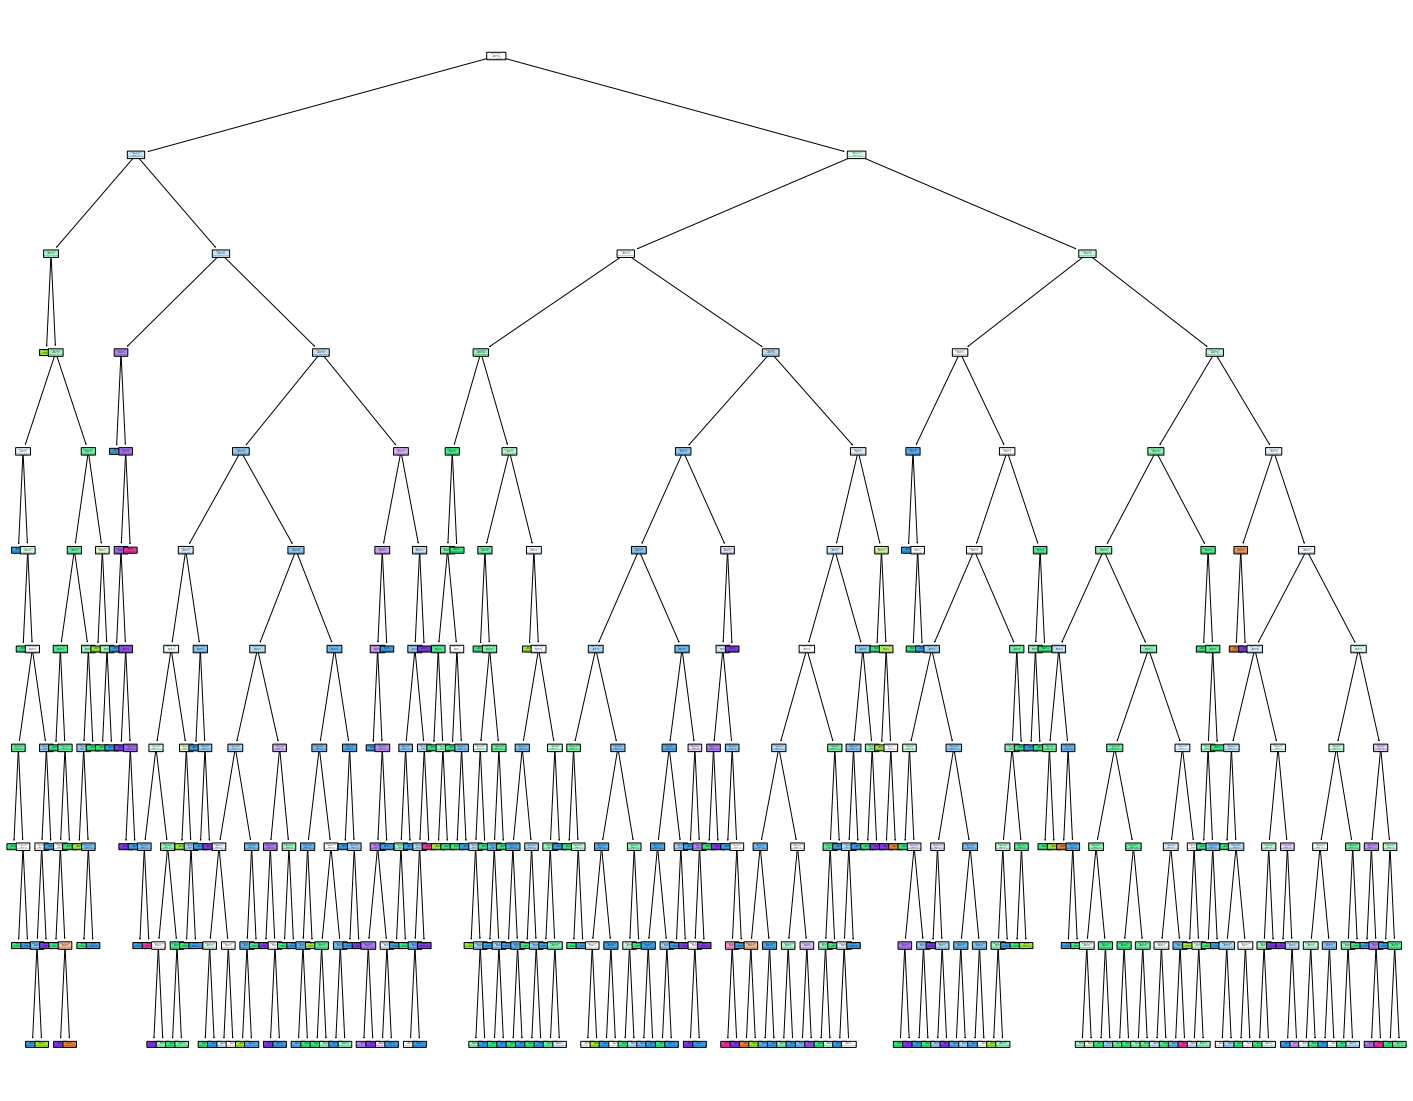

In [56]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(modelo_RF.estimators_[1], 
                   feature_names=dataStanX.columns,  
                   class_names=["Cuenta1","Cuenta2","Cuenta3","Cuenta4","Cuenta5","Cuenta6"],
                   filled=True,
                   rounded=True)

In [57]:
print(classification_report(dataStanRF['Cuenta'].values, dataStanRF['Prediccion_Cuenta'].values, target_names=["Cuenta1","Cuenta2","Cuenta3","Cuenta4","Cuenta5","Cuenta6"]))

              precision    recall  f1-score   support

     Cuenta1       1.00      0.70      0.82        10
     Cuenta2       0.96      0.51      0.67        53
     Cuenta3       0.88      0.94      0.91       681
     Cuenta4       0.88      0.89      0.89       638
     Cuenta5       0.95      0.86      0.90       199
     Cuenta6       1.00      0.28      0.43        18

    accuracy                           0.89      1599
   macro avg       0.94      0.70      0.77      1599
weighted avg       0.89      0.89      0.89      1599



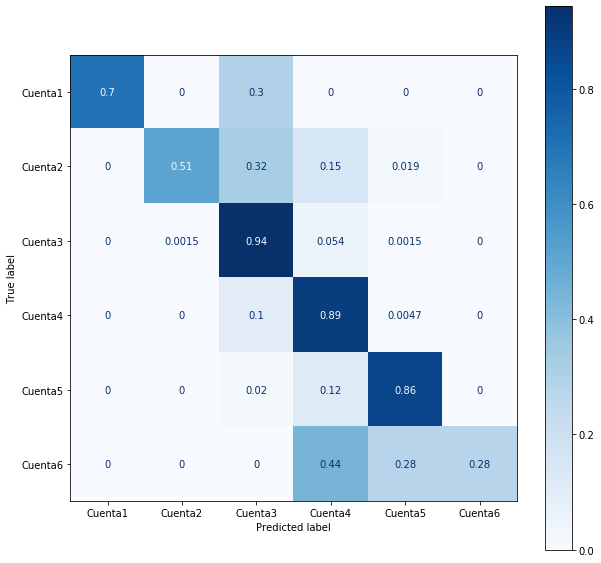

In [58]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_confusion_matrix(modelo_RF, dataStanX, dataStanRF['Cuenta'].values,
                     display_labels=["Cuenta1","Cuenta2","Cuenta3","Cuenta4","Cuenta5","Cuenta6"],
                                 cmap=plt.cm.Blues,
                                 normalize='true', ax=ax)

plt.show()